In [5]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "fire_detection/train"
categories = ["fire","not_fire"]
nb_classes = len(categories)

image_w = 128
image_h = 128

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("fire_detection_images_2.npy", xy)

print("ok", len(y))

fire  파일 길이 :  4211
fire  :  fire_detection/train/fire\fire_0_0.jpg
fire  :  fire_detection/train/fire\fire_0_2461.jpg
fire  :  fire_detection/train/fire\fire_0_3958.jpg
fire  :  fire_detection/train/fire\fire_0_5416.jpg
fire  :  fire_detection/train/fire\fire_0_6914.jpg
fire  :  fire_detection/train/fire\fire_0_8405.jpg
fire  :  fire_detection/train/fire\fire_0_9969.jpg
not_fire  파일 길이 :  4236
not_fire  :  fire_detection/train/not_fire\not_fire_0_0.jpg
not_fire  :  fire_detection/train/not_fire\not_fire_0_2424.jpg
not_fire  :  fire_detection/train/not_fire\not_fire_0_3965.jpg
not_fire  :  fire_detection/train/not_fire\not_fire_0_5392.jpg
not_fire  :  fire_detection/train/not_fire\not_fire_0_685.jpg
not_fire  :  fire_detection/train/not_fire\not_fire_0_8418.jpg
not_fire  :  fire_detection/train/not_fire\not_fire_0_9927.jpg
ok 8447


In [84]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load("fire_detection_images_2.npy")
print(X_train.shape)
print(X_train.shape[0])

(6335, 128, 128, 3)
6335


In [85]:
categories = ["fire","not_fire"]
nb_classes = len(categories)

X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [86]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/fire_detection_images_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [87]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)      

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=26, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 6335 samples, validate on 2112 samples
Epoch 1/26
6335/6335 [==============================] - 83s 13ms/step - loss: 0.4519 - accuracy: 0.7893 - val_loss: 0.2590 - val_accuracy: 0.9332

Epoch 00001: val_loss improved from inf to 0.25899, saving model to ./model/fire_detection_images_classification.model
Epoch 2/26
6335/6335 [==============================] - 79s 12ms/step - loss: 0.1588 - accuracy: 0.9427 - val_loss: 0.3963 - val_accuracy: 0.8253

Epoch 00002: val_loss did not improve from 0.25899
Epoch 3/26
6335/6335 [==============================] - 80s 13ms/step - loss: 0.0891 - accuracy: 0.9684 - val_loss: 0.0425 - val_accuracy: 0.9872

Epoch 00003: val_loss improved from 0.25899 to 0.04254, saving model to ./model/fire_detection_images_classification.model
Epoch 4/26
6335/6335 [==============================] - 80s 13ms/step - loss: 0.0555 - accuracy: 0.9800 - val_loss: 0.0304 - val_accuracy: 0.9877

Epoch 00004: val_loss improved from 0.04254 to 0.03043, saving model to

In [79]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

2112/2112 [==============================] - 6s 3ms/step
정확도 : 0.9943


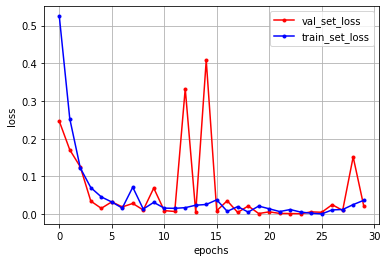

In [80]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

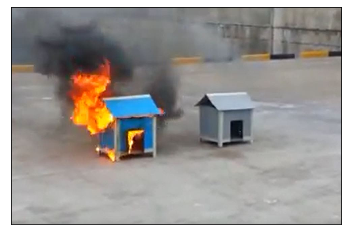

화재가 감지되었습니다.
화재일 확률 : 100.0
화재가 아닐 확률 : 0.0



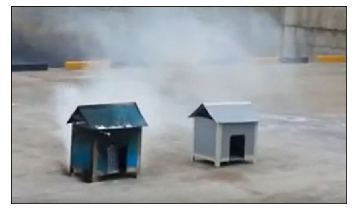

화재가 감지되지 않았습니다.
화재가 아닐 확률 : 89.8597
화재일 확률 : 10.1403



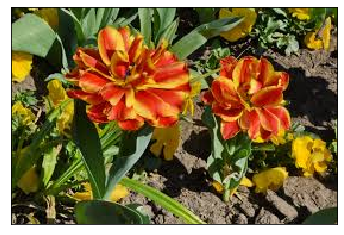

화재가 감지되지 않았습니다.
화재가 아닐 확률 : 66.991
화재일 확률 : 33.009



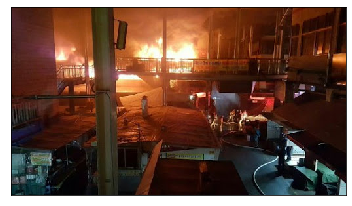

화재가 감지되었습니다.
화재일 확률 : 99.9982
화재가 아닐 확률 : 0.0018



In [51]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
import cv2
from matplotlib import pyplot as plt

import tensorflow as tf

seed = 5
tf.set_random_seed(seed)
np.random.seed(seed)

image_w = 128
image_h = 128

pixels = image_h * image_w * 3

model = load_model('./model/fire_detection_images_classification.model')

j = 0
for j in range(1,5):
    caltech_dir = "test/test"+str(j)+".jpg"
    view_img = cv2.imread(caltech_dir, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(view_img)
    view_img2 = cv2.merge([r,g,b])
    
    plt.imshow(view_img2)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    X = []
    filenames = []
    files = glob.glob(caltech_dir)
    
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        
        filenames.append(f)
        X.append(data)
        
        X = np.array(X)
        X = X.astype(float) / 255
        
        prediction = model.predict(X)
        np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
        
        for k in prediction:
            if k[0] >= 0.9:
                print("화재가 감지되었습니다.")
                print("화재일 확률 : "+str(round(k[0]*100, 4)))
                print("화재가 아닐 확률 : "+str(round(k[1]*100, 4)))
                print("")
            else:
                print("화재가 감지되지 않았습니다.")
                print("화재가 아닐 확률 : "+str(round(k[1]*100, 4)))
                print("화재일 확률 : "+str(round(k[0]*100, 4)))
                print("")